In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, SparseObjective

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import autograd

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

simulate_data = False

if not simulate_data:
    analysis_name = 'simulated_data_small'
    #analysis_name = 'simulated_data_large'
    #analysis_name = 'criteo_subsampled'

    data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                            'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')
    json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

    json_file = open(json_filename, 'r')
    json_dat = json.load(json_file)
    json_file.close()

    stan_dat = json_dat['stan_dat']
    vp_base = json_dat['vp_base']

    print(stan_dat.keys())
    K = stan_dat['K'][0]
    NObs = stan_dat['N'][0]
    NG = stan_dat['NG'][0]
    #N = NObs / NG
    y_g_vec = np.array(stan_dat['y_group'])
    y_vec = np.array(stan_dat['y'])
    x_mat = np.array(stan_dat['x'])
    
    # TODO: don't rely on vp_base, set it here.
    glmm_par = logit_glmm.get_glmm_parameters(
        K=K, NG=NG, 
        mu_info_min=vp_base['mu_info_min'][0],
        tau_alpha_min=vp_base['tau_alpha_min'][0],
        tau_beta_min=vp_base['tau_beta_min'][0],
        beta_diag_min=vp_base['beta_diag_min'][0],
        u_info_min=vp_base['u_info_min'][0])

    # Define a class to contain prior parameters.
    prior_par = logit_glmm.get_default_prior_params(K)
    prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

    beta_prior_info = np.linalg.inv(np.array(stan_dat['beta_prior_var']))
    prior_par['beta_prior_info'].set(beta_prior_info)

    prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
    prior_par['mu_prior_info'].set(1 / stan_dat['mu_prior_var'][0])
    
    prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
    prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])
    
    # An index set to make sure jacobians match the order expected by R.
    prior_par_indices = copy.deepcopy(prior_par)
    prior_par_indices.set_name('Prior Indices')
    prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))
else:
    # Simulate data instead of loading it if you like
    N = 200     # observations per group
    K = 5      # dimension of regressors
    NG = 200      # number of groups

    # Generate data

    true_beta = np.array(range(5))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0

    x_mat, y_g_vec, y_vec, true_rho, true_u = \
        logit_glmm.simulate_data(N, NG, true_beta, true_mu, true_tau)

    prior_par = logit_glmm.get_default_prior_params(K)

    glmm_par = logit_glmm.get_glmm_parameters(
        K=K, NG=NG, 
        mu_info_min=0.001, tau_alpha_min=0.001,
        tau_beta_min=0.001, beta_diag_min=0.001,
        u_info_min=0.001)


print(np.mean(y_vec))

dict_keys(['mu_prior_var_c', 'mu_prior_epsilon', 'mu_prior_t', 'tau_prior_beta', 'y_group', 'x', 'y', 'K', 'tau_prior_alpha', 'beta_prior_var', 'mu_prior_mean', 'NG', 'beta_prior_mean', 'mu_prior_mean_c', 'mu_prior_var', 'N'])
0.324


In [3]:


glmm_init = False
if glmm_init and not simulate_data:
    # Initialize with GLMM.
    # If you use this, don't forget to add the computation time to your final VB time!
    glmm_time = 0.

    glmm_fit = json_dat['glmm_fit']
    glmm_par['mu'].mean.set(glmm_fit['mu_mean'][0])
    glmm_par['mu'].info.set(1.0)

    tau_mean = 1.0 / glmm_fit['mu_sd'][0] ** 2
    tau_var = 1.0
    glmm_par['tau'].shape.set((tau_mean ** 2) / tau_var)
    glmm_par['tau'].rate.set(tau_var / tau_mean)

    glmm_par['beta'].mean.set(np.array(glmm_fit['beta_mean']))
    glmm_par['beta'].info.set(np.eye(K))

    glmm_par['u'].mean.set(np.array(glmm_fit['u_map']))
    glmm_par['u'].info.set(np.full(NG, 1.0))

    free_par_vec = glmm_par.get_free()
else:
    glmm_time = 0.
    glmm_par['mu'].mean.set(0.0)
    glmm_par['mu'].info.set(1.0)

    glmm_par['tau'].shape.set(2.0)
    glmm_par['tau'].rate.set(2.0)

    glmm_par['beta'].mean.set(np.full(K, 0.0))
    glmm_par['beta'].info.set(np.eye(K))

    glmm_par['u'].mean.set(np.full(NG, 0.0))
    glmm_par['u'].info.set(np.full(NG, 1.0))

free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)


In [25]:
# Define moment parameters

moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector)

model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=10)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

objective = Objective(model.glmm_par, model.get_kl)
objective.fun_free(free_par_vec)

# # PriorHess evaluates the second order derivative d2 EPrior / dpar dprior_par
def get_e_log_prior(prior_vec, free_par):
    model.glmm_par.set_free(free_par)
    model.prior_par.set_vector(prior_vec)
    return model.get_e_log_prior()

get_prior_model_grad = autograd.grad(get_e_log_prior, argnum=0)
get_prior_hess = autograd.jacobian(get_prior_model_grad, argnum=1)

import timeit

time_num = 10

num_draws = 3
model.set_gh_points(num_draws)
print('num_draws = ', num_draws)
print('\tFunction time:',
      timeit.timeit(lambda: objective.fun_free(free_par_vec), number=time_num) / time_num)

print('\tGrad time:', 
      timeit.timeit(lambda: objective.fun_free_grad(free_par_vec), number=time_num) / time_num)

print('\tHessian vector product time:',
      timeit.timeit(lambda: objective.fun_free_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num)

prior_vec = model.prior_par.get_vector()
prior_hess_time = time.time()
get_prior_hess(prior_vec, init_par_vec)
prior_hess_time = time.time() - prior_hess_time
print('\tPrior hess time: ', prior_hess_time)


num_draws =  3
	Function time: 0.001237309600401204
	Grad time: 0.006700699100474594
	Hessian vector product time: 0.0151023004000308
	Prior hess time:  0.06992936134338379


In [5]:
glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, num_gh_points, gtol=1e-6, maxiter=500):
    model.set_gh_points(num_gh_points)
    objective.logger.initialize()
    objective.logger.print_every = 5
    vb_opt = optimize.minimize(
        lambda par: objective.fun_free(par, verbose=True),
        x0=trust_init,
        method='trust-ncg',
        jac=objective.fun_free_grad,
        hessp=objective.fun_free_hvp,
        tol=1e-6, options={'maxiter': maxiter, 'disp': True, 'gtol': gtol })
    return vb_opt.x

def get_moment_vec(vb_opt_x):
    glmm_par_opt.set_free(vb_opt_x)
    set_moments(glmm_par_opt, moment_par)
    return moment_par.get_vector()


In [6]:
import pandas as pd
#print(glmm_par)

x_t_x = np.matmul(x_mat.transpose(), x_mat)
x_t_y = np.matmul(x_mat.transpose(), y_vec)
beta_init = np.linalg.solve(x_t_x, x_t_y)
#print(beta_init)
#plt.plot(sp.special.expit(np.matmul(x_mat, beta_init)), y_vec, 'k.')

df = pd.DataFrame({ 'y_g': y_g_vec, 'y': y_vec}).groupby('y_g')
#print(df.sum())
u_init = np.array(df.sum()) / np.array(df.count()['y'])
#plt.figure()
print(np.min(y_g_vec))
#plt.plot(u_init[y_g_vec], y_vec, 'k.')


0


In [7]:
# Optimize.

print('Running Newton Trust Region with few draws.')
num_gh_points = 4
vb_time = time.time()
opt_x = tr_optimize(init_par_vec, num_gh_points, gtol=1e-6, maxiter=200)
vb_time_opt_1 = time.time() - vb_time
#print('vb_time_opt_1: ', vb_time_opt_1)
vb_time = time.time() - vb_time

# print('Running Newton Trust Region with more draws')
# num_gh_points = 20
# # vb_time = time.time()
# opt_x = tr_optimize(opt_x, num_gh_points, gtol=1e-6, maxiter=100)
# vb_time = time.time() - vb_time

print('VB time: ', vb_time)
print('Done.')

Running Newton Trust Region with few draws.
Iter  0  value:  [ 1034.21559918]
	x_diff:  inf
Iter  5  value:  [ 230.72578534]
	x_diff:  1.7943124529
Iter  10  value:  [ 71.45829508]
	x_diff:  0.480945879431
Iter  15  value:  [ 66.48333587]
	x_diff:  0.250398688
Iter  20  value:  [ 66.47504252]
	x_diff:  3.71947088312e-06
Optimization terminated successfully.
         Current function value: 66.475043
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
         Hessian evaluations: 0
VB time:  4.193744659423828
Done.


In [8]:

glmm_par.set_free(opt_x)
if simulate_data:
    print('Fit beta: ', glmm_par['beta'].e())
    print('True beta: ', true_beta)
    
    print('Fit mu: ', glmm_par['mu'].e())
    print('True mu: ', true_mu)
    
    print('Fit tau: ', glmm_par['tau'].e())
    print('True tau: ', true_tau)
    
    plt.plot(true_u, true_u, 'r.')
    plt.plot(true_u, glmm_par['u'].e(), 'k.')
    

In [9]:
print(vb_time_opt_1)
print(vb_time - vb_time_opt_1)


4.19372034072876
2.4318695068359375e-05


VB time:  4.193744659423828
[ 0.75057332  1.97883706  3.47870431  4.40648953  5.51727613]
GLMM Parameters:
	mu:
mu_mean: [-3.76040345]
mu_info: [ 90.88414399]
	tau:
tau_shape: [ 53.00000001]
tau_rate: [ 58.32242008]
	beta:
beta_mean:
[ 0.75057332  1.97883706  3.47870431  4.40648953  5.51727613]
beta_info:
[[ 18.91233359   1.45969765   1.67317171   1.09378781   1.37572464]
 [  1.45969765  18.97411872  -0.59499145   1.52430818  -1.09454369]
 [  1.67317171  -0.59499145  13.3652071   -0.5136844   -2.48218174]
 [  1.09378781   1.52430818  -0.5136844   15.00974593  -3.36010378]
 [  1.37572464  -1.09454369  -2.48218174  -3.36010378  12.75644721]]
	u:
u_mean:
[-3.18980068 -3.74860003 -3.97913849 -4.70410933 -3.69093714 -4.09411354
 -3.87183779 -3.94172707 -2.82666986 -3.6359192  -2.88333634 -3.4187051
 -3.9128449  -4.00891724 -3.76399226 -3.17962139 -3.44450381 -4.41156221
 -3.99633008 -3.1490323  -2.68846162 -3.83548647 -3.84089282 -4.82842504
 -3.35567167 -4.53142791 -3.8309061  -3.7678797  

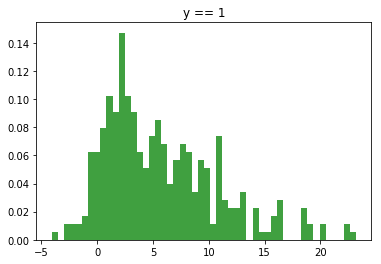

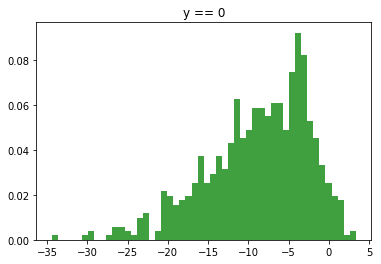

In [10]:
print('VB time: ', vb_time)

import scipy as sp

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(opt_x)
#glmm_par_opt.set_free(init_par_vec)
print(glmm_par_opt['beta'].e())
print(glmm_par_opt)

#plt.plot(glmm_par_opt['u'].e(), glmm_par_opt['u'].var(), 'k.')

e_beta = glmm_par_opt['beta'].e()
e_u = glmm_par_opt['u'].e()[model.y_g_vec]

z_mean = e_u + np.matmul(model.x_mat, e_beta)
#plt.plot(sp.special.expit(z_mean), model.y_vec, 'k.')


plt.figure()
plt.hist(z_mean[model.y_vec == 1], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 1')

plt.figure()
plt.hist(z_mean[model.y_vec == 0], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 0')




In [11]:
# Get the Hessians at the number of draws used for optimization.

hess_time = time.time()
print('KL Hessian...\n')
kl_hess = objective.fun_free_hessian(opt_x)

print('Log prior Hessian...\n')
log_prior_hess = get_prior_hess(prior_par.get_vector(), opt_x)

hess_time =  time.time() - hess_time
elbo_hess = -kl_hess

print('hess_time: %f' % hess_time)

KL Hessian...

Log prior Hessian...

hess_time: 1.861995


In [12]:
moment_jac = get_moment_jacobian(opt_x)
lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

vp_indices = copy.deepcopy(glmm_par_opt)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))

In [26]:
if not simulate_data:
    # Write the result to a JSON file for use in R.
    
    run_name = 'production'
    result_dict = { 'glmm_par_opt': glmm_par_opt.dictval(), 'run_name': run_name,
                    'vb_time': vb_time, 'hess_time': hess_time, 'num_gh_points': num_gh_points, 
                    'lrvb_cov': lrvb_cov.tolist(), 'moment_jac': moment_jac.tolist(),
                    'elbo_hess': elbo_hess.tolist(), 'log_prior_hess': log_prior_hess.tolist() }

    result_json = json.dumps(result_dict)
    json_output_filename = os.path.join(data_dir, '%s_python_vb_results.json' % analysis_name)
    json_file = open(json_output_filename, 'w')
    json_file.write(result_json)
    json_file.close()
    print(json_output_filename)

    
    
    pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
    pickle_output = open(pickle_output_filename, 'wb')

    # TODO: save everything needed to reconstruct glmm_par, since the parameters cannot be pickled
    # due to having function pointers.
    # Unlike with JSON, numpy arrays can be pickled.
    pickle_result_dict = {  'glmm_par_dictval': glmm_par_opt.dictval(),
                            'vb_opt_par': vb_results.,
                            'run_name': run_name,
                            'vb_time': vb_time,
                            'hess_time': hess_time,
                            'num_gh_points': num_gh_points, 
                            'lrvb_cov': np.squeeze(lrvb_cov),
                            'moment_jac': np.squeeze(moment_jac),
                            'elbo_hess': np.squeeze(elbo_hess),
                            'log_prior_hess': np.squeeze(log_prior_hess) }

    # Pickle dictionary using protocol 0.
    pickle.dump(pickle_result_dict, pickle_output)
    pickle_output.close()
    
    print(pickle_output_filename)


    

/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/simulated_data_small_python_vb_results.json


AttributeError: Can't pickle local object 'jacobian.<locals>.jacfun'

In [30]:
# pkl_file = open(pickle_output_filename, 'rb')
# vb_results = pickle.load(pkl_file)
# pkl_file.close()



print(glmm_par_opt.)


GLMM Parameters:
	mu:
mu_mean: [-3.76040345]
mu_info: [ 90.88414399]
	tau:
tau_shape: [ 53.00000001]
tau_rate: [ 58.32242008]
	beta:
beta_mean:
[ 0.75057332  1.97883706  3.47870431  4.40648953  5.51727613]
beta_info:
[[ 18.91233359   1.45969765   1.67317171   1.09378781   1.37572464]
 [  1.45969765  18.97411872  -0.59499145   1.52430818  -1.09454369]
 [  1.67317171  -0.59499145  13.3652071   -0.5136844   -2.48218174]
 [  1.09378781   1.52430818  -0.5136844   15.00974593  -3.36010378]
 [  1.37572464  -1.09454369  -2.48218174  -3.36010378  12.75644721]]
	u:
u_mean:
[-3.18980068 -3.74860003 -3.97913849 -4.70410933 -3.69093714 -4.09411354
 -3.87183779 -3.94172707 -2.82666986 -3.6359192  -2.88333634 -3.4187051
 -3.9128449  -4.00891724 -3.76399226 -3.17962139 -3.44450381 -4.41156221
 -3.99633008 -3.1490323  -2.68846162 -3.83548647 -3.84089282 -4.82842504
 -3.35567167 -4.53142791 -3.8309061  -3.7678797  -3.42111923 -3.06340288
 -3.7316747  -3.36630898 -3.67263039 -4.11260265 -3.34343928 -5.59